In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import io, time, json, string
import requests
import urllib.request
from pathlib import Path
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import nltk
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from langdetect import detect
torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
def getReviews(url,game,console):

    user_agent = {'User-agent': 'Mozilla/5.0'}
    response = requests.get(url, headers = user_agent)
    soup = BeautifulSoup(response.text, 'html.parser')
    review_dict = {'Rating':[], 'Review':[],'Game':[],'Console':[],'Thumbsup':[],'TotalThumbs':[]}

    limit = 1
    
    if soup.find('li', class_='page last_page'):
        pages = soup.find('li', class_='page last_page').text
        limit = int(pages.replace('…',''))
        
    if limit > 125:
        ulim = limit
        llim = ulim -20
        limit = 100
        for i in range(limit):
            cur_url = url+'?page='+str(i)
            response = requests.get(cur_url, headers = user_agent)
            soup = BeautifulSoup(response.text, 'html.parser')
            for review in soup.find_all('div', class_='review_content'): 

                if review.find('span', class_='blurb blurb_expanded'): 
                    text = review.find('span', class_='blurb blurb_expanded').text
                else:
                    text = review.find('div',class_='review_body').text

                if review.find('div', class_='helpful_summary thumb_count'):
                    thumbs = int(review.find('span', class_='total_ups').text)
                    total = int(review.find('span',class_='total_thumbs').text)
                rating = int(review.find('div', class_='review_grade').find_all('div')[0].text)
                try:
                    if detect(text) == 'en' and rating <= 10:                
                        review_dict['Rating'].append(rating)
                        review_dict['Review'].append(text)
                        review_dict['Game'].append(game)
                        review_dict['Console'].append(console)
                        review_dict['Thumbsup'].append(thumbs)
                        review_dict['TotalThumbs'].append(total)
                except:
                    print(text)
        for i in range(llim,ulim):
            cur_url = url+'?page='+str(i)
            response = requests.get(cur_url, headers = user_agent)
            soup = BeautifulSoup(response.text, 'html.parser')
            for review in soup.find_all('div', class_='review_content'): 

                if review.find('span', class_='blurb blurb_expanded'): 
                    text = review.find('span', class_='blurb blurb_expanded').text
                else:
                    text = review.find('div',class_='review_body').text

                if review.find('div', class_='helpful_summary thumb_count'):
                    thumbs = int(review.find('span', class_='total_ups').text)
                    total = int(review.find('span',class_='total_thumbs').text)
                rating = int(review.find('div', class_='review_grade').find_all('div')[0].text)
                try:
                    if detect(text) == 'en' and rating <= 10:                
                        review_dict['Rating'].append(rating)
                        review_dict['Review'].append(text)
                        review_dict['Game'].append(game)
                        review_dict['Console'].append(console)
                        review_dict['Thumbsup'].append(thumbs)
                        review_dict['TotalThumbs'].append(total)
                except:
                    print(text)
    else:
        for i in range(limit):
            cur_url = url+'?page='+str(i)
            response = requests.get(cur_url, headers = user_agent)
            soup = BeautifulSoup(response.text, 'html.parser')
            for review in soup.find_all('div', class_='review_content'): 

                if review.find('span', class_='blurb blurb_expanded'): 
                    text = review.find('span', class_='blurb blurb_expanded').text
                else:
                    text = review.find('div',class_='review_body').text

                if review.find('div', class_='helpful_summary thumb_count'):
                    thumbs = int(review.find('span', class_='total_ups').text)
                    total = int(review.find('span',class_='total_thumbs').text)
                rating = int(review.find('div', class_='review_grade').find_all('div')[0].text)
                try:
                    if detect(text) == 'en' and rating <= 10:                
                        review_dict['Rating'].append(rating)
                        review_dict['Review'].append(text)
                        review_dict['Game'].append(game)
                        review_dict['Console'].append(console)
                        review_dict['Thumbsup'].append(thumbs)
                        review_dict['TotalThumbs'].append(total)
                except:
                    print(text)

    return review_dict



In [3]:
def getURLs(url):
    user_agent = {'User-agent': 'Mozilla/5.0'}
    response = requests.get(url, headers = user_agent)
    soup = BeautifulSoup(response.text, 'html.parser')
    games = []
    for summary in soup.find_all('td', class_='clamp-summary-wrap'):
        games.append((summary.find('a',class_='title').text,summary.find('div', class_='platform').find('span',class_='data').text.strip()))
    return games

In [4]:
def collectReviews(url):
    d = {'Rating':[], 'Review':[], 'Game':[], 'Console':[],'Thumbsup':[],'TotalThumbs':[]}
    for (game,console) in url:
        g = game.replace(' & ', ' ')
        g = g.replace(' / ', ' ')
        g = g.replace(' ', '-')
        g = g.replace('.', '')
        g = g.replace(':', '')
        g = g.replace(';', '')
        g = g.replace(',', '')
        g = g.replace(']', '')
        g = g.replace('[', '')
        g = g.replace('#', '')
        g = g.replace('\'', '')
        c = console.replace(' ', '-')
        temp_d = getReviews('https://www.metacritic.com/game/'+c.lower()+'/'+g.lower()+'/user-reviews', game, console)
        d['Review'] = d['Review'] + temp_d['Review']
        d['Rating'] = d['Rating'] + temp_d['Rating']
        d['Game'] = d['Game'] + temp_d['Game']
        d['Console'] = d['Console']+temp_d['Console']
        d['Thumbsup'] = d['Thumbsup']+temp_d['Thumbsup']
        d['TotalThumbs'] = d['TotalThumbs']+temp_d['TotalThumbs']
    return d

In [5]:
d = {'Rating':[], 'Review':[],'Game':[], 'Console':[],'Thumbsup':[],'TotalThumbs':[]}
for i in range(2013,2021):
    url = getURLs('https://www.metacritic.com/browse/games/score/metascore/year/all/filtered?year_selected='+str(i)+'&distribution=&sort=desc&view=detailed')
    reviews = collectReviews(url)
    d['Review'] = d['Review'] + reviews['Review']
    d['Rating'] = d['Rating'] + reviews['Rating']
    d['Game'] = d['Game'] + reviews['Game']
    d['Console'] = d['Console']+reviews['Console']
    d['Thumbsup'] = d['Thumbsup']+reviews['Thumbsup']
    d['TotalThumbs'] = d['TotalThumbs']+reviews['TotalThumbs']
reviews = pd.DataFrame(d)


10/10 ................................................................................................................................................


 


 


10/10 ..............................................................................................................................


///////////////////////////////////////////////////////////////////////////


10/10......................................................................

123456789/*/*/1111111111111111111111111 123456789/*/*/1111111111111111111111111 123456789/*/*/1111111111111111111111111 123456789/*/*/1111111111111111111111111 123456789/*/*/1111111111111111111111111 123456789/*/*/1111111111111111111111111 123456789/*/*/1111111111111111111111111 123456789/*/*/1111111111111111111111111 123456789/*/*/1111111111111111111111111 123456789/*/*/1111111111111111111111111 123456789/*/*/1111111111111111111111111 123456789/*/*/1111111111111111111111111 123456789/*/*/1111111111111111111111111 123456789/*/*/11111111111111



9/10............................................................................






++++ 


7/10 -----------------------------------------------------------------------------------------


7/10 .............................................................................................................


:`(    .


09/10......................................................................


10/10.............................................................................


8/10 ----------------------------------------------------------------------


///////////////////////////////////////////////////////////////////////////


--------------------------------------------------------------------------------


07/10......................................................................


---------------------------------------------------------------------------


¡¡!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!








ເລື່ອງບໍ່ດີເລື່ອງບໍ່ດີເລື່

In [6]:
gamers = []
for i in range(2013,2021):
    url = getURLs('https://www.metacritic.com/browse/games/score/metascore/year/all/filtered?year_selected='+str(i)+'&distribution=&sort=desc&view=detailed')
    for (g,c) in url:
        gamers.append(g)
    

135687


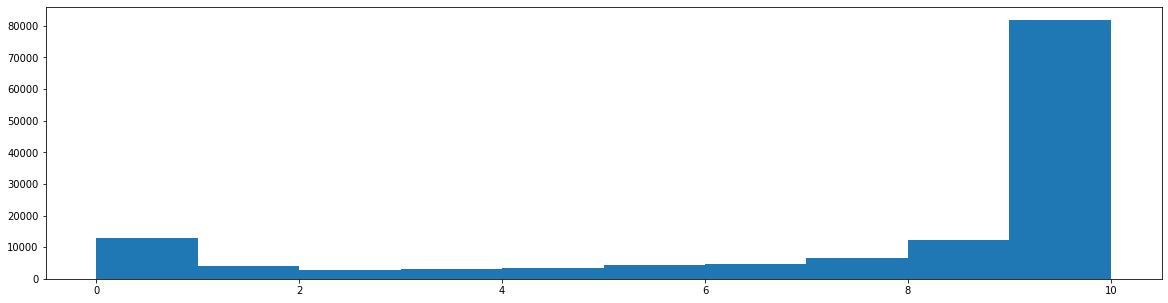

In [11]:
reviews.head()
plt.figure(figsize=(20,5))
plt.hist(reviews['Rating'])
print(len(reviews))

(array([1.035e+03, 3.770e+02, 2.380e+02, 1.470e+02, 1.190e+02, 4.100e+01,
        4.100e+01, 3.000e+01, 4.100e+01, 2.800e+01, 2.900e+01, 2.900e+01,
        1.900e+01, 1.100e+01, 6.000e+00, 6.000e+00, 7.000e+00, 8.000e+00,
        8.000e+00, 5.000e+00, 1.000e+00, 4.000e+00, 2.000e+00, 5.000e+00,
        2.000e+00, 4.000e+00, 2.000e+00, 4.000e+00, 2.000e+00, 3.000e+00,
        4.000e+00, 5.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        4.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 5.000e+00, 0.000e+00, 3.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

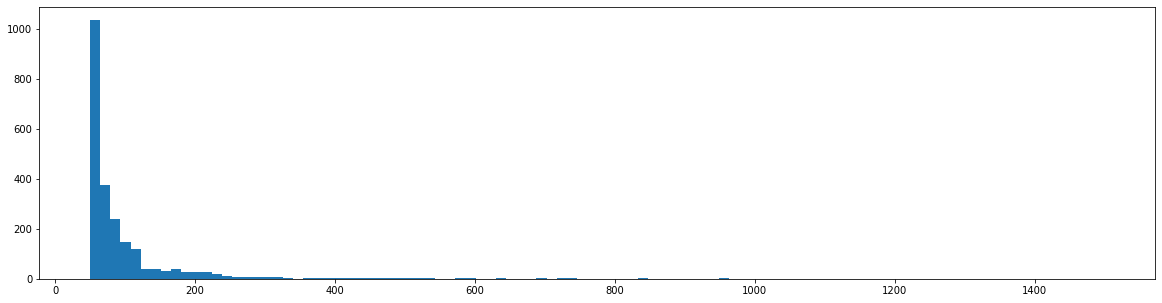

In [8]:
plt.figure(figsize=(20,5))
plt.hist(reviews['Thumbsup'].sort_values(),bins = 100, range = [50,1500])

(array([7.128e+03, 3.285e+03, 2.048e+03, 1.168e+03, 7.240e+02, 5.120e+02,
        3.660e+02, 2.610e+02, 1.830e+02, 1.190e+02, 1.250e+02, 9.100e+01,
        5.900e+01, 4.900e+01, 4.700e+01, 4.600e+01, 4.700e+01, 4.100e+01,
        3.400e+01, 3.000e+01, 3.600e+01, 1.900e+01, 1.900e+01, 1.500e+01,
        1.500e+01, 1.300e+01, 1.400e+01, 3.000e+00, 9.000e+00, 8.000e+00,
        1.700e+01, 1.200e+01, 1.100e+01, 7.000e+00, 7.000e+00, 6.000e+00,
        6.000e+00, 3.000e+00, 3.000e+00, 5.000e+00, 1.000e+00, 3.000e+00,
        2.000e+00, 1.000e+00, 2.000e+00, 6.000e+00, 2.000e+00, 3.000e+00,
        4.000e+00, 5.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 1.000e+00,
        3.000e+00, 2.000e+00, 3.000e+00, 4.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 3.000e+00, 3.000e+00, 1.000e+00, 3.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 2.000e+00,
        0.000e+00, 3.000e+00, 1.000e+0

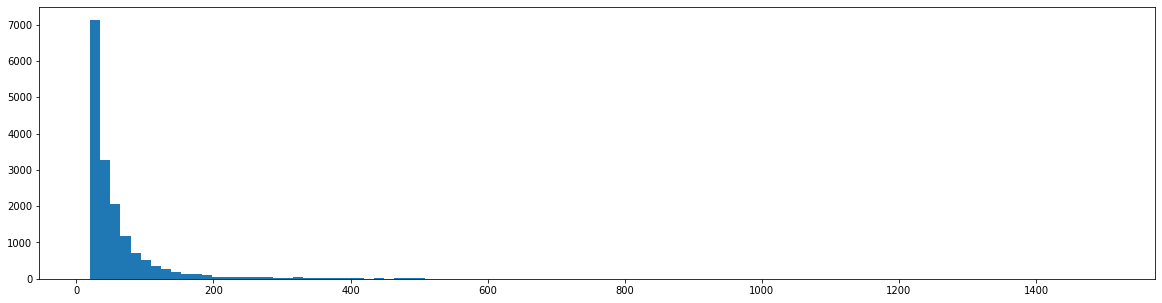

In [9]:
plt.figure(figsize=(20,5))
plt.hist(reviews['TotalThumbs'].sort_values(),bins = 100, range = [20,1500])

(array([1.2375e+04, 1.0000e+00, 2.3000e+01, 2.2000e+01, 2.3000e+01,
        6.1000e+01, 7.6000e+01, 7.3000e+01, 9.2000e+01, 1.0300e+02,
        1.7400e+02, 1.3100e+02, 1.5700e+02, 1.6900e+02, 8.1000e+01,
        2.6300e+02, 3.0900e+02, 1.4900e+02, 4.4500e+02, 9.0000e+01,
        2.0800e+02, 5.3600e+02, 1.4200e+02, 2.4000e+02, 7.8400e+02,
        5.9000e+01, 1.6300e+02, 2.8400e+02, 2.2800e+02, 7.2000e+01,
        1.2240e+03, 1.5500e+02, 2.5000e+02, 4.1900e+02, 2.8000e+02,
        3.0400e+02, 1.0300e+02, 2.2040e+03, 1.3900e+02, 1.6000e+02,
        4.5800e+02, 1.7600e+02, 8.4000e+02, 1.1400e+02, 4.9200e+02,
        1.2500e+02, 3.7600e+02, 1.8300e+02, 1.4800e+02, 4.3310e+03,
        2.0000e+01, 1.2900e+02, 2.7400e+02, 2.7400e+02, 3.5200e+02,
        1.9500e+02, 7.0600e+02, 3.2400e+02, 2.1200e+02, 5.5000e+01,
        1.9190e+03, 2.3600e+02, 4.0600e+02, 1.7400e+02, 1.0040e+03,
        3.3900e+02, 7.7000e+02, 2.6600e+02, 4.7200e+02, 3.6200e+02,
        4.0900e+02, 3.9900e+02, 1.5400e+02, 1.10

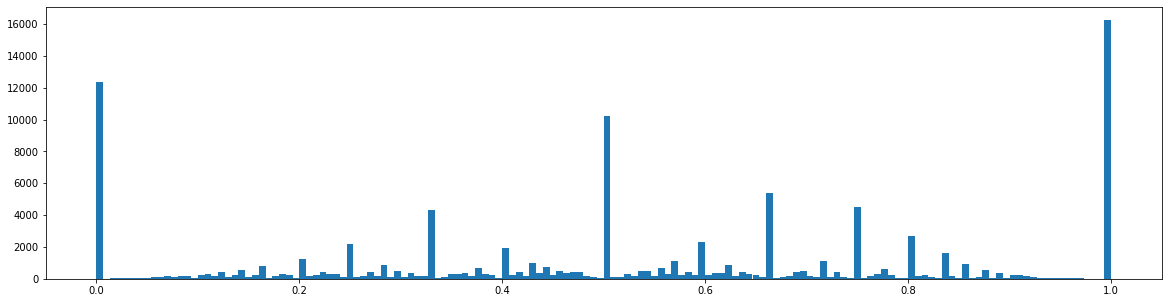

In [10]:
r = reviews[reviews['TotalThumbs'] != 0]
r['Thumbsup']/r['TotalThumbs']
plt.figure(figsize=(20,5))
plt.hist(r['Thumbsup']/r['TotalThumbs'],bins = 150 )

In [77]:
def pe(text):
    url = 'https://blocktribe.com/companies/?companies_per_page=200'
    user_agent = {'User-agent': 'Mozilla/5.0'}
    response = requests.get(url, headers = user_agent)
    soup = BeautifulSoup(response.text, 'html.parser')
    comp_dict = {'Posting':[]}

    total = soup.find('h1', class_="title__primary title__primary-small title__centered")
    companies = total.text.strip()
    companies = int(companies.split(' ')[0])
    r = companies//50

    for u in range(1,r):
        url = 'https://blocktribe.com/companies/?company=&l=&r=&page='+str(u)
        user_agent = {'User-agent': 'Mozilla/5.0'}
        response = requests.get(url, headers = user_agent)
        soup = BeautifulSoup(response.text, 'html.parser')
        for comp in soup.find_all('div', class_='featured-companies__name'): 
            comp_dict['Posting'].append(comp.text.strip())

    companies = ' | '.join(comp_dict['Posting'])
    companies = companies.replace('.','\.')
    companies = companies.replace(')','\)')
    companies = companies.replace('(','\(')
    companies = companies.replace('+','\+')
    companies = companies.replace('?','\?')
    companies = companies.replace('*','\*')
    r = re.compile(companies)
    find = r.findall(text)
    found_comp = [word for word, word_count in Counter(find).most_common(1)]
    if found_comp:
        return found_comp[0]
    return 'Not Found'

In [78]:
import re
from collections import Counter
from datetime import datetime
print(datetime.now())
print(pe(" Location: San Francisco, CA Coinbase has built the world's leading compliant cryptocurrency platform serving over 30 million accounts in more than 100 countries. With multiple successful products, and our vocal advocacy for blockchain technology, we have played a major part in mainstream awareness and adoption of cryptocurrency. We are proud to offer an entire suite of products that are helping build the cryptoeconomy, and increase economic freedom around the world. There are a few things we look for across all hires we make at Coinbase, regardless of role or team. First, we assess whether a candidate demonstrates our values: Clear Communication, Positive Energy, Efficient Execution, and Continuous Learning. Second, we look for signals that a candidate will thrive in a culture like ours, where we default to trust, embrace feedback, disrupt ourselves, and expect sustained high performance because we play as a championship team. Finally, we seek people with the desire and capacity to build and share expertise in the frontier technologies of crypto and blockchain, in whatever way is most relevant to their role. Read more about our values and culture here. At Coinbase, maintaining a high security bar earns us the trust of millions of customers. They choose to buy, sell and store billions of dollars worth of digital assets in our products. As a Software Engineer on the Infrastructure Security team, you'll build services and features that reduce that set and maintain the highest standards of security and privacy for our engineers and users. The Infrastructure Security team is a new team that works directly with the Infrastructure team architecting, advising, and building solutions that make the Coinbase engineering platform secure and let our engineers focus on building great products. Our work touches all facets of the engineering pipeline, from development and deployment, to core infrastructure and configuration, to the cross between SRE and Security. You'll work with these infrastructure teams while building security specific solutions that compliment the overall platform.Ã<83>\u0083\u0082Ã<83>\u0082Ã<82>Â  What you'll be doing (ie. job duties): Building systems that discover, inform, and maintain expectations about our infrastructure so that engineers can focus on building products and when they need to make decisions to make good ones. Contribute security functionality to the core Coinbase Infrastructure by working closely with Infrastructure engineers to extend services that they are building. Help Infrastructure engineers develop secure systems by advising on secure patterns and practices. What we look for in you (ie. job requirements): You exhibit our core values: clear communication, positive energy, continuous learning, and efficient execution You have strong software engineering skills in languages such as Go, Java, or Python You have experience with cloud-native architectures You are interested in security and thinking about how things can go wrong Nice to haves: You enjoy wrangling complex problems and datasets - we often deal with messy or voluminous datasets such as configuration across our fleet or terabytes of logs, so interest in modern data management tools that help us find signal in the noise will be beneficial. Interest in cryptography or privacy engineering - we use cryptography across our organization to protect our users, and bringing standardization and integration into our platform will help meet our mission of helping engineers focus on building products. We have cryptographic engineers that build and validate primitives, but knowing how and where to use them will be helpful. Experience working in a high security and/or highly regulated industry - we are both, and have to work to build highly constrained architectures that are as painless as possible, while remaining highly transparent for ease of compliance and audit. Coinbase is committed to diversity in its workforce and is proud to be an equal opportunity employer and to review all of our job postings to minimize biased language. Coinbase does not make hiring or employment decisions on the basis of race, color, religion, creed, gender, national origin, age, disability, veteran status, marital status, pregnancy, sex, gender expression or identity, sexual orientation, citizenship, or any other basis protected by applicable local, state or federal law. Coinbase will also consider for employment qualified applicants with arrest and conviction records in a manner consistent with San Francisco's Fair Chance Ordinance and similar local laws. Global Data Privacy Notice for Job Candidates and Applicants Depending on your location, the General Data Protection Regulation (GDPR) and California Consumer Privacy Act (CCPA) may regulate the way we manage the data of job applicants.Ã<83>\u0083\u0082Ã<83>\u0082Ã<82>Â  Our full notice outlining how your data will be processed as part of the application procedure for application locations is available here: Ireland/EU , United Kingdom , and California .Ã<83>\u0083\u0082Ã<83>\u0082Ã<82>Â  By submitting your application, you are agreeing to our use and processing of your data as required. Email me jobs like this About Coinbase Coinbase is the world\u2019s most popular way to buy and sell bitcoin and ethereum. Founded in June of 2012, Coinbase is a digital currency wallet and platform where merchants and consumers can transact with new digital currencies like bitcoin and ethereum. We're based in San Francisco, California. Bitcoin is the world's most widely used alternative currency with a total market cap of approximately $10 billion. The bitcoin network is made up of thousands of computers run by individuals all over the world. Ã<83>\u0083\u0082Ã<83>\u0082Ã<82>Â  Our mission is to create an open financial system for the world An open financial system is one that is not controlled by any one country or company (just like the internet did for distributing information). We think this is the highest leverage way to bring about more economic freedom, innovation, efficiency, and equality of opportunity in the world. We have a ten year plan to get there. Imagine if every payment in the world was as fast, cheap, and global as sending an email. Imagine if anyone who had an idea for a product could have customers all over the world from day one. Imagine if anyone with a smartphone had access to the the same financial services we enjoy in the developed world. An open financial system can be a great equalizer and lift billions out of poverty while accelerating the pace of innovation around the world. This is the best way we know to change the world. "))
print(datetime.now())

2020-08-02 00:57:00.826247
 Coinbase 
2020-08-02 00:57:10.106380
